In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

sns.set_theme()

from src.utils.explo.explo import describe_dataframe

# Data Exploration - Beer Advocate

In [11]:
df_ba_beers = pd.read_csv("src/data/beer_advocate/beers.csv")
df_ba_breweries = pd.read_csv("src/data/beer_advocate/breweries.csv")
df_ba_users = pd.read_csv("src/data/beer_advocate/users.csv")
df_ba_ratings = pd.read_csv("src/data/beer_advocate/ratings.csv")

## Beers

[BeerAdvocate] Dataframe contains 280823 rows and 15 columns


,beer_id,brewery_id,beer_name,beer_style,ratings_count,reviews_count,ratings_average,ratings_ba_score,ratings_bros_score,beer_alcohol_by_volume,ratings_average_computed,zscore,matching_ratings_count,matching_ratings_average,beer_global_style
0,166064,39912,Nashe Moskovskoe,Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN,Pale Lager
1,166065,39912,Nashe Pivovskoe,Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN,Pale Lager
2,166066,39912,Nashe Shakhterskoe,Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN,Pale Lager
3,166067,39912,Nashe Zhigulevskoe,Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN,Pale Lager
4,166063,39912,Zhivoe,Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN,Pale Lager


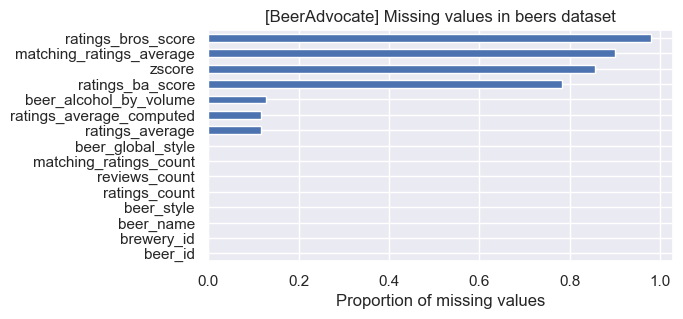

In [12]:
describe_dataframe(df_ba_beers, "BeerAdvocate", "beers")
df_ba_beers.head(5)

*Interpretation*:

We observe that the columns ratings_bros_score, matching_ratings_average, and zscore have the highest proportion of missing values, approaching nearly 100%. Other columns, such as ratings_ba_score and beer_alcohol_by_volume, also have missing values but at a lower proportion. Columns like beer_id, brewery_id, and beer_name have no missing values. 

The missing data (columns with NaNs) are not used in the current analysis, thus it is not a problem.

### Breweries

[BeerAdvocate] Quartiles of the number of beers per brewery : [ 3.  8. 20.]


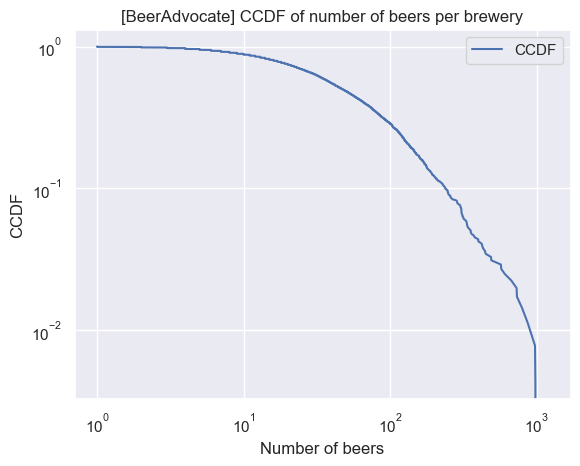

In [13]:
df_beers_by_brewery = (
    df_ba_beers.groupby("brewery_id")
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .sort_values("count", ascending=True)
)
df_beers_by_brewery["CCDF"] = (
    1 - df_beers_by_brewery["count"].cumsum(0) / df_beers_by_brewery["count"].sum()
)
df_beers_by_brewery.plot(
    x="count",
    y="CCDF",
    logx=True,
    logy=True,
    title="[BeerAdvocate] CCDF of number of beers per brewery",
    xlabel="Number of beers",
    ylabel="CCDF",
)
print(
    f"[BeerAdvocate] Quartiles of the number of beers per brewery : {df_beers_by_brewery['count'].quantile([0.25, 0.5, 0.75]).values}"
)

*Interpetation*: 

First, this graphic represents the probability for a brewery to have more than a number of beers given in the $x$-axis. 

The curve decreases gradually, indicating that while most breweries produce a limited number of beers. To be more precise, more than $10\%$ of breweries produce $100$ beers or more.

### Beer Style

In [14]:
print(
    f"[BeerAdvocate] Dataset contains data about {df_ba_beers['beer_style'].nunique()} styles of beer"
)

[BeerAdvocate] Dataset contains data about 104 styles of beer


During pre-processing, we grouped several beer styles together into broader categories based on those proposed on the BeerAdvocate website, to create a taxonomy that was easier to analyze.

<Axes: title={'center': '[BeerAdvocate] Number of beers per global style'}, xlabel='Beer style', ylabel='Number of beers'>

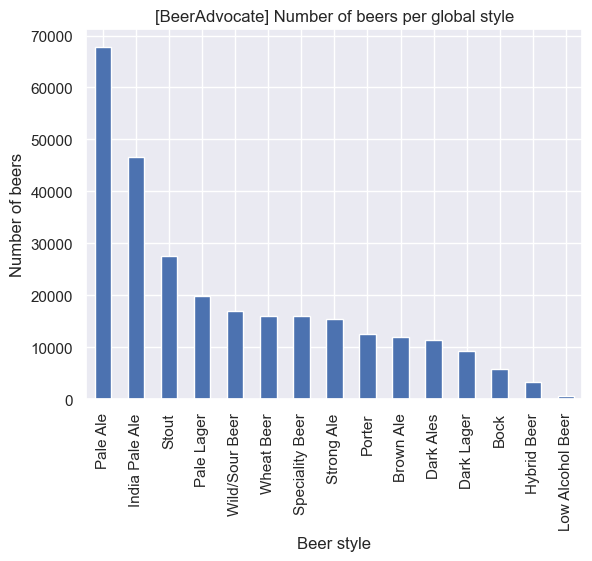

In [15]:
df_ba_beers.groupby("beer_global_style").size().sort_values(ascending=False).plot(
    kind="bar",
    title="[BeerAdvocate] Number of beers per global style",
    xlabel="Beer style",
    ylabel="Number of beers",
)

*Intepretation*:

The chart shows that Pale Ale, IPA, and Stout dominate beer production, reflecting their popularity. Styles like Pale Lager and Wheat Beer are moderately common, while Hybrid Beer, Bock, and Low Alcohol Beer are niche, highlighting a strong preference for a few key styles.

### Number of ratings

[BeerAdvocate] 11.69% (32841) of beers have no ratings
[BeerAdvocate] Quartiles of the number of ratings per beer : [1. 2. 8.]


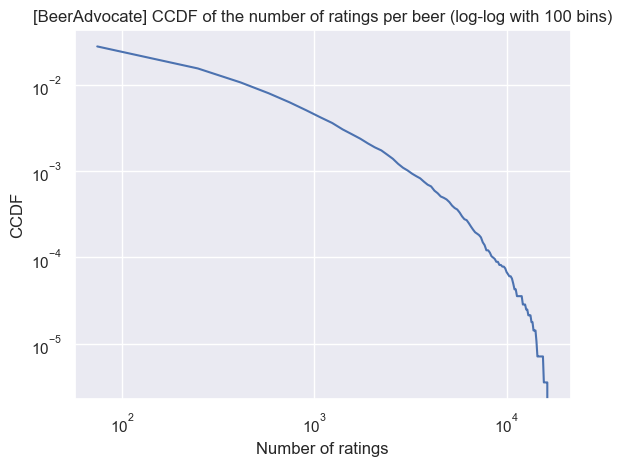

In [16]:
bin_counts = pd.cut(df_ba_beers["ratings_count"], 100).value_counts().sort_index()
ratings_per_beer_CCDF = 1 - bin_counts.cumsum(0) / bin_counts.sum()

sns.lineplot(x=[interval.mid for interval in bin_counts.index], y=ratings_per_beer_CCDF)
plt.title(
    "[BeerAdvocate] CCDF of the number of ratings per beer (log-log with 100 bins)"
)
plt.xlabel("Number of ratings")
plt.ylabel("CCDF")
plt.xscale("log")
plt.yscale("log")

print(
    f"[BeerAdvocate] {(df_ba_beers['ratings_count'] == 0).mean() * 100:.2f}% ({(df_ba_beers['ratings_count'] == 0).sum()}) of beers have no ratings"
)
print(
    f"[BeerAdvocate] Quartiles of the number of ratings per beer : {df_ba_beers['ratings_count'].quantile([0.25, 0.5, 0.75]).values}"
)

*Interpretation*:

The CCDF shows that only a bit more than 10% of beers have at least 100 ratings, indicating that the majority of beers have very few ratings. This is why we need to be cautious in analysis, as conclusions may be skewed by limited data for most beers.

### Average rating

Text(0, 0.5, 'Average rating (/5)')

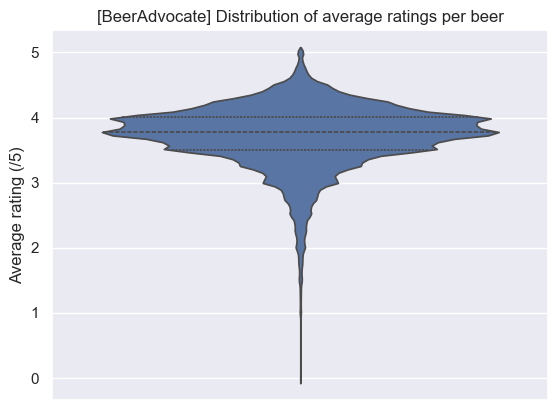

In [17]:
sns.violinplot(df_ba_beers["ratings_average"], inner="quart")
plt.title("[BeerAdvocate] Distribution of average ratings per beer")
plt.ylabel("Average rating (/5)")

Interpretation:

We observe that most of beers have a rating between $3.5/5$ and $4/5$, with a mean of $3.75/5$. This could give us a first glimpse of the user's notation: they are gracious. For example, a not liked beer has a rating around $2$.

Text(0.5, 0, 'Average rating (/5)')

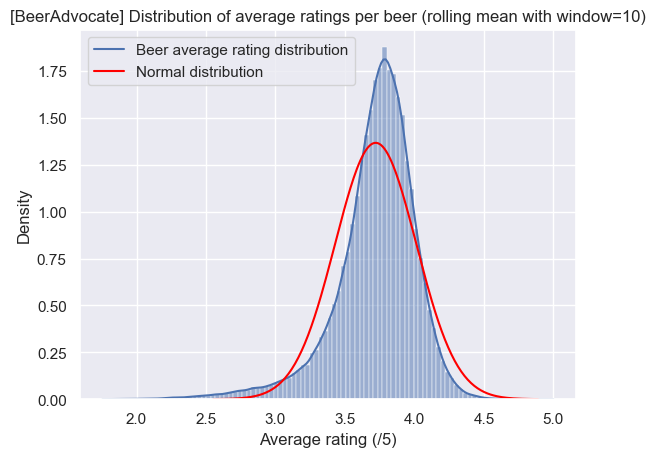

In [18]:
ratings_average_rolling = (
    df_ba_beers[df_ba_beers["ratings_average"].notna()]["ratings_average"]
    .rolling(10)
    .mean()[9:]
)
sns.histplot(ratings_average_rolling, bins=100, kde=True, stat="density")


ratings_average_mean = ratings_average_rolling.mean()
ratings_average_std = ratings_average_rolling.std()

x = np.linspace(
    ratings_average_mean - 4 * ratings_average_std,
    ratings_average_mean + 4 * ratings_average_std,
    200,
)
y = stats.norm.pdf(x, ratings_average_mean, ratings_average_std)

sns.lineplot(x=x, y=y, color="red")

plt.title(
    "[BeerAdvocate] Distribution of average ratings per beer (rolling mean with window=10)"
)
plt.legend(["Beer average rating distribution", "Normal distribution"])
plt.xlabel("Average rating (/5)")

*Interpretation*:

We observe that the distribution of average ratings per beer, visualized with a rolling mean (window = 10) and compared to a normal distribution, reveals a slightly skewed pattern. Most averages fall between $3.5$ and $4.0$, indicating a general tendency for positive ratings. The rolling mean smooths out fluctuations, highlighting that the normal distribution does not perfectly align, suggesting that the actual ratings have a non-normal, slightly skewed nature with a peak around $3.75$.

In [19]:
ALPHA = 0.01
normality_test_results = stats.normaltest(df_ba_beers["ratings_average"].dropna())
print(f"[BeerAdvocate] {normality_test_results}")
print(
    f"[BeerAdvocate] Normality test for average ratings per beer : reject null hypothesis = {normality_test_results.pvalue < ALPHA}"
)

[BeerAdvocate] NormaltestResult(statistic=np.float64(56015.453990368434), pvalue=np.float64(0.0))
[BeerAdvocate] Normality test for average ratings per beer : reject null hypothesis = True


## Breweries

[BeerAdvocate] Dataframe contains 16758 rows and 6 columns
[BeerAdvocate] Dataset contains data about breweries in 195 countries


,brewery_id,brewery_name,brewery_beers_count,brewery_country,brewery_region,brewery_country_code
0,39912,Abdysh-Ata (Абдыш Ата),5,Kyrgyzstan,NaN,KGZ
1,39913,Arpa (АРПА),1,Kyrgyzstan,NaN,KGZ
2,39914,Bear Beer,4,Kyrgyzstan,NaN,KGZ
3,39915,Blonder Pub,4,Kyrgyzstan,NaN,KGZ
4,39916,Kellers Bier,2,Kyrgyzstan,NaN,KGZ


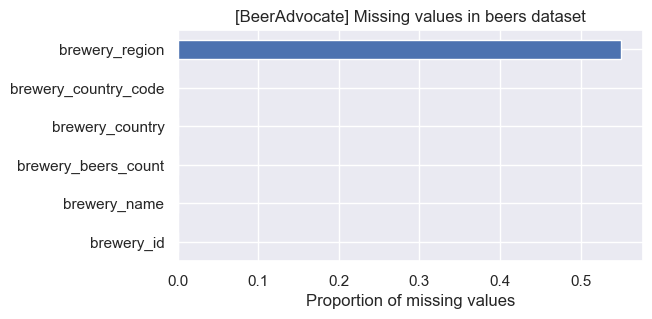

In [20]:
describe_dataframe(df_ba_breweries, "BeerAdvocate", "beers")
print(
    f'[BeerAdvocate] Dataset contains data about breweries in {df_ba_breweries["brewery_country"].nunique()} countries'
)
df_ba_breweries.head(5)

*Interpretation*: 

The chart shows the proportion of missing values for various brewery-related attributes in the dataset. The brewery_region column has the highest proportion of missing values, exceeding 50%, while other attributes such as brewery_country_code, brewery_country, brewery_beers_count, brewery_name, and brewery_id have little to no missing data. This indicates that while most information is well-documented, brewery_region might require special handling or exclusion from certain analyses.

### Country

[BeerAdvocate] Quartiles of the number of breweries per country : [ 1.5  4.  23. ]


<Axes: title={'center': '[BeerAdvocate] Number of breweries per country (50 largers producers)'}, xlabel='Country', ylabel='Number of breweries (log scale)'>

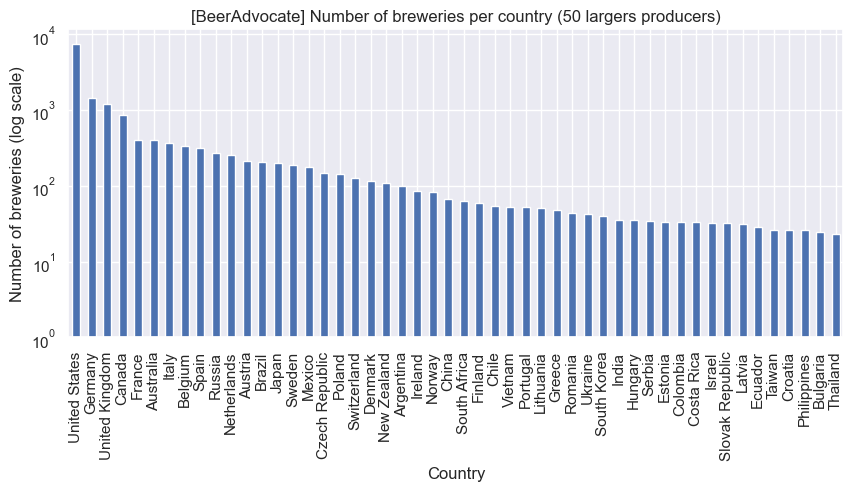

In [21]:
print(
    f'[BeerAdvocate] Quartiles of the number of breweries per country : {df_ba_breweries["brewery_country"].value_counts().quantile([0.25, 0.5, 0.75]).values}'
)

df_ba_breweries["brewery_country"].value_counts().head(50).plot(
    kind="bar",
    log=True,
    figsize=(10, 4),
    title="[BeerAdvocate] Number of breweries per country (50 largers producers)",
    xlabel="Country",
    ylabel="Number of breweries (log scale)",
)

*Interpretation*: 

The plot shows the number of breweries per country (log scale), showing that the United States, Germany, and the UK lead in brewery counts, being the only countries with over 1,000 breweries. However this plot is not really meaningful given that Germany is sligthly above Canada in the list, but the area of Canada is larger than Germany's. This suggests that while brewery numbers are high in some countries, factors such as area and population density could provide more meaningful insights into their distribution.

## Users

[BeerAdvocate] Dataframe contains 153704 rows and 8 columns


,user_ratings_count,user_reviews_count,user_id,user_name,user_created_date,user_country,user_region,user_country_code
0,7820,465,nmann08.184925,nmann08,1.199704e+09,United States,Washington,USA
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,United States,New York,USA
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,United Kingdom,Northern Ireland,GBR
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,United Kingdom,Northern Ireland,GBR
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,United Kingdom,Northern Ireland,GBR


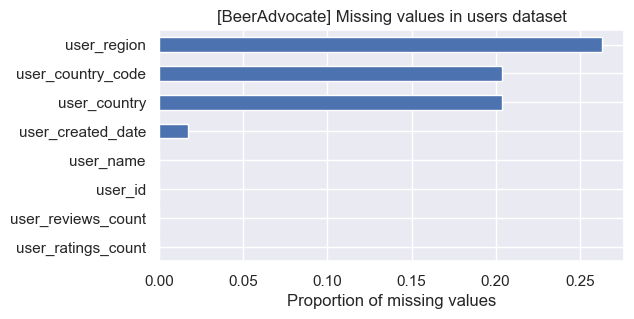

In [22]:
describe_dataframe(df_ba_users, "BeerAdvocate", "users")
df_ba_users.head(5)

*Interpretation*:

The chart shows the proportion of missing values in the users dataset. The user_region, user_country_code, and user_country columns have the most missing values, with over 20% of the data missing. This could make it harder to analyze user locations. Other columns, like user_created_date, user_name, user_id, user_reviews_count, and user_ratings_count, have very few or no missing values, so they can be used for analysis without problems.

### Ratings

[BeerAdvocate] Quartiles of the number of ratings per user : [ 1.  3. 16.]


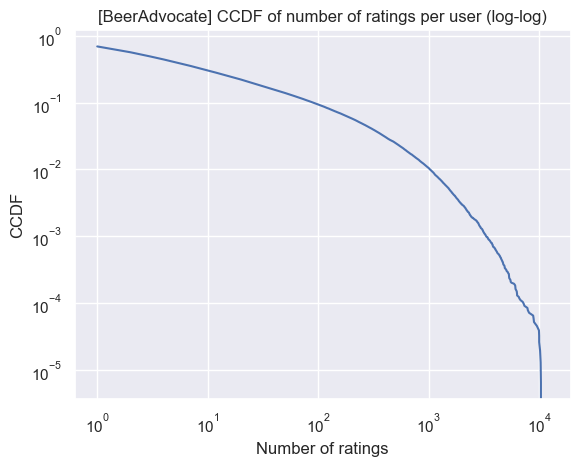

In [23]:
ratings_per_user_CCDF = (
    1
    - df_ba_users["user_ratings_count"].value_counts().sort_index().cumsum()
    / df_ba_users.shape[0]
)

ratings_per_user_CCDF.plot(
    x=df_ba_users["user_ratings_count"].value_counts().sort_index(),
    y=ratings_per_user_CCDF,
    logx=True,
    logy=True,
    title="[BeerAdvocate] CCDF of number of ratings per user (log-log)",
    xlabel="Number of ratings",
    ylabel="CCDF",
)

print(
    f"[BeerAdvocate] Quartiles of the number of ratings per user : {df_ba_users['user_ratings_count'].quantile([0.25, 0.5, 0.75]).values}"
)

*Interpretation*:
 
This graph is important to understand the rating habits of the users. Only $10\%$ of users have more than $100$ ratings. So if we want to draw conclusions we need to focus on individuals that have a large number of ratings, and thus reduce the sample that will be used for the analysis.

*Interpretation*:
 
This graph is important to understand the rating habits of the users. Only $10\%$ of users have more than $100$ ratings. So if we want to draw conclusions we need to focus on individuals that have a large number of ratings, and thus reduce the sample that will be used for the analysis.

### Country

In [24]:
df_ba_users["user_country"].value_counts().head(10)

user_country
United States     113223
Canada              3324
United Kingdom       945
Australia            520
Germany              372
Sweden               308
Netherlands          271
Brazil               267
Belgium              227
Mexico               193
Name: count, dtype: int64

In [25]:
print(
    f'[BeerAdvocate] Users from United States represent {df_ba_users["user_country"].value_counts(normalize=True).loc['United States'] * 100:.2f}% of accounts'
)

[BeerAdvocate] Users from United States represent 92.48% of accounts


<Axes: title={'center': '[BeerAdvocate] Number of users per country'}, xlabel='Country', ylabel='Number of users (log scale)'>

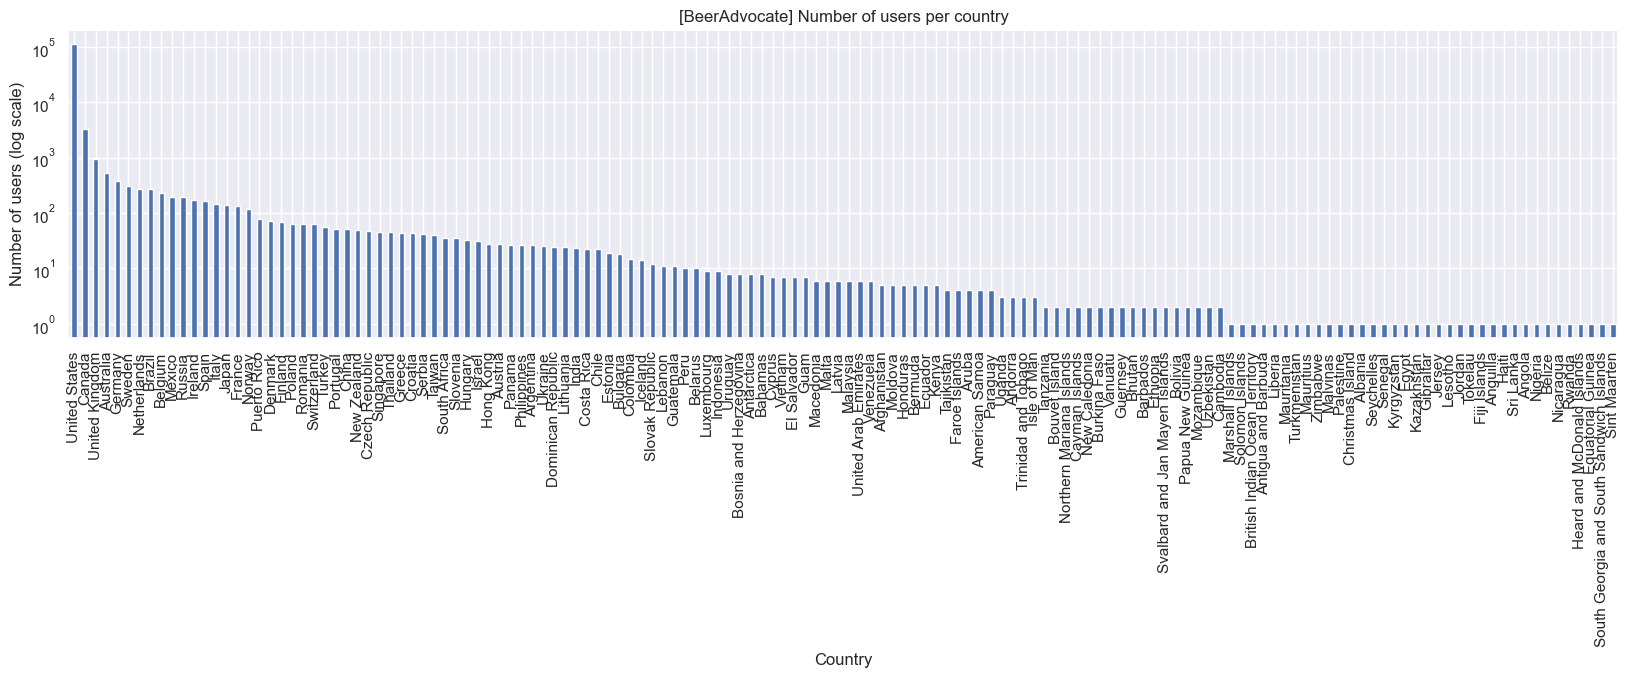

In [26]:
df_ba_users["user_country"].value_counts().plot(
    kind="bar",
    figsize=(20, 4),
    logy=True,
    title="[BeerAdvocate] Number of users per country",
    xlabel="Country",
    ylabel="Number of users (log scale)",
)

*Interpretation*:

The chart shows the number of users per country (on a log scale), with the United States having the overwhelming majority of users. This is expected since the website is based in the U.S., making it more popular among American users. Other countries, such as Canada, the United Kingdom, and Australia, also have significant user representation, likely due to language and cultural similarities. However, user numbers sharply decline for countries outside these regions, reflecting the localized reach and popularity of the platform.

### Creation date

In [27]:
PRESENT_TIME = df_ba_users["user_created_date"].max()
user_years_since_creation = (
    (PRESENT_TIME - df_ba_users["user_created_date"]) / 3600 / 24 / 365.25
)

In [28]:
print(
    f"[BeerAdvocate] Mean of the number of years since user creation : {user_years_since_creation.mean():.3f}"
)
print(
    f"[BeerAdvocate] Quartiles of the number of years since user creation : {user_years_since_creation.quantile([0.25, 0.5, 0.75]).values}"
)

[BeerAdvocate] Mean of the number of years since user creation : 4.571
[BeerAdvocate] Quartiles of the number of years since user creation : [2.65560119 3.47148072 6.28610541]


<Axes: title={'center': '[BeerAdvocate] Distribution of time elapsed since user account creation (years)'}, xlabel='Years since user creation', ylabel='Number of users'>

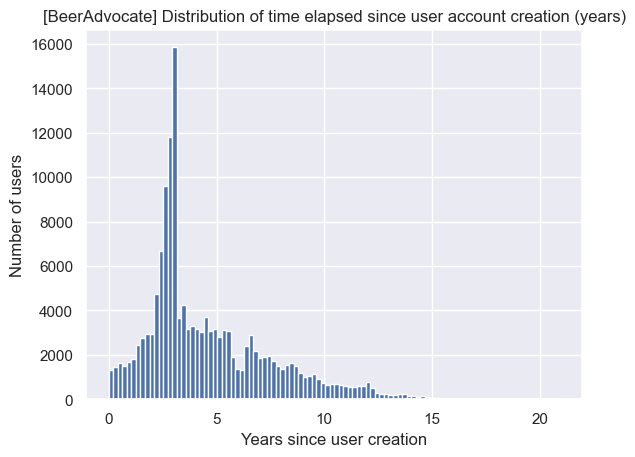

In [29]:
user_years_since_creation.plot(
    kind="hist",
    bins=100,
    title="[BeerAdvocate] Distribution of time elapsed since user account creation (years)",
    xlabel="Years since user creation",
    ylabel="Number of users",
)

*Interpretation*:

The chart shows the distribution of time since user account creation in years. Most accounts were created within the past 5 years, with a peak around 3 years ago. However, as the accounts become older, their numbers decrease significantly. It is important to consider that many older accounts might no longer be active, potentially becoming "dead" accounts. This could influence analysis, as inactive users may not contribute to current platform activity or ratings, and a focus on newer accounts might provide a more accurate representation of active users.

*Interpretation*:

First, there was a moderate increase in the number of accounts created between 15 and 7 years ago. Then, from 7 to 6 years ago, there was a sharp decline. Later, there was a huge trend of account creation around 3 years ago. And from 2 years ago to now there has been a decrease.

However, this graph does not tell us if there are dead accounts. 

## Ratings

[BeerAdvocate] Dataframe contains 8393032 rows and 20 columns


,user_id,beer_id,brewery_id,date,review,rating,overall,aroma,appearance,palate,taste,text,user_past_ratings_count,user_past_ratings_average,beer_past_ratings_count,beer_past_ratings_average,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,gini_impurity
0,nmann08.184925,142544,37262,1440064800,True,2.88,3.0,2.75,3.25,3.25,2.75,"From a bottle, pours a piss yellow color with ...",5915,3.742926,0,NaN,Pale Lager,324,3.183796,0.947660
1,stjamesgate.163714,19590,10093,1235127600,True,3.67,3.5,3.50,3.00,3.50,4.00,Pours pale copper with a thin head that quickl...,27,3.788148,3,3.903333,Pale Ale,4,3.765000,0.881834
2,mdagnew.19527,19590,10093,1142247600,True,3.73,3.5,3.50,4.00,3.50,4.00,"500ml Bottle bought from The Vintage, Antrim.....",133,4.017068,2,3.990000,Pale Ale,30,4.018667,0.952044
3,helloloser12345.10867,19590,10093,1101898800,True,3.98,4.5,3.50,4.00,4.00,4.00,Serving: 500ml brown bottlePour: Good head wit...,1,3.650000,1,4.000000,Pale Ale,2,3.815000,0.000000
4,cypressbob.3708,19590,10093,1093860000,True,4.00,4.0,4.00,4.00,4.00,4.00,"500ml bottlePours with a light, slightly hazy ...",168,3.229583,0,NaN,Pale Ale,44,3.501818,0.837813


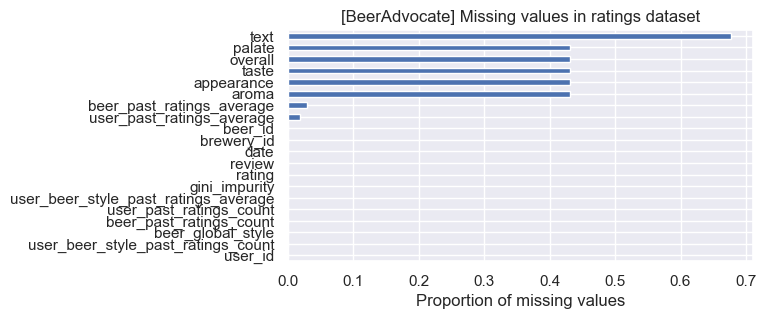

In [30]:
describe_dataframe(df_ba_ratings, "BeerAdvocate", "ratings")
df_ba_ratings.head(5)

*Interpretation*:

This graph shows the proportion of missing values for different attributes of the ratings dataset. We can see that this dataset has a good number of missing values. For past_ratings_average it is normal because it is a shifted running avergage.

### Date

<Axes: title={'center': '[BeerAdvocate] Number of ratings per quarters'}, xlabel='Quarter', ylabel='Number of ratings'>

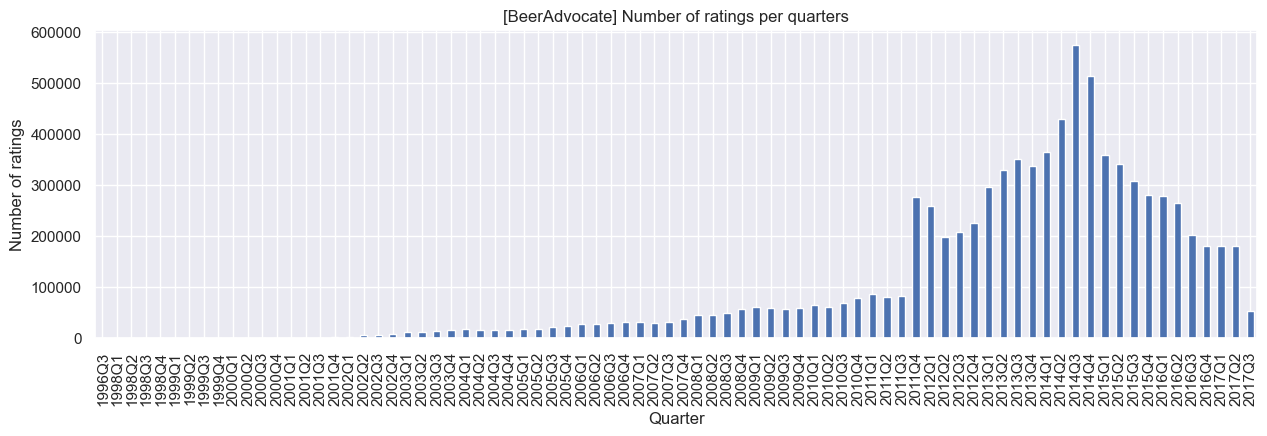

In [31]:
pd.to_datetime(df_ba_ratings["date"], unit="s").dt.to_period(
    "Q"
).value_counts().sort_index().plot(
    kind="bar",
    figsize=(15, 4),
    title="[BeerAdvocate] Number of ratings per quarters",
    xlabel="Quarter",
    ylabel="Number of ratings",
)

*Interpretation*:

This chart shows the number of ratings per quarters. We observe an slight increase between the first quarter of $2002$, until the third quarter of $2011$. Then the increase becomes stronger and attain a peak of approximately $55000$ ratings at the third quarter of $2014$. Then there was a controlled decrease of the number of ratings.

### Text

In [32]:
print(
    f"[BeerAdvocate] {(df_ba_ratings['text'].notna()).mean() * 100:.2f}% ({(df_ba_ratings['text'].notna()).sum()}) of the reviews contain a text"
)

print(
    f'[BeerAdvocate] Average length of text in reviews : {df_ba_ratings["text"].str.len().mean():.2f} characters'
)
print(
    f'[BeerAdvocate] Quartiles of the length of text in reviews : {df_ba_ratings["text"].str.len().quantile([0.25, 0.5, 0.75]).values} characters'
)

print(
    f'[BeerAdvocate] Average length of text in reviews : {(df_ba_ratings["text"].str.count(' ') + 1).mean():.2f} words'
)
print(
    f'[BeerAdvocate] Quartiles of the length of text in reviews : {(df_ba_ratings["text"].str.count(' ') + 1).quantile([0.25, 0.5, 0.75]).values} words'
)

[BeerAdvocate] 32.36% (2715709) of the reviews contain a text
[BeerAdvocate] Average length of text in reviews : 648.43 characters
[BeerAdvocate] Quartiles of the length of text in reviews : [377. 561. 816.] characters
[BeerAdvocate] Average length of text in reviews : 113.71 words
[BeerAdvocate] Quartiles of the length of text in reviews : [ 66.  98. 143.] words


Text(0.5, 0, 'Text length')

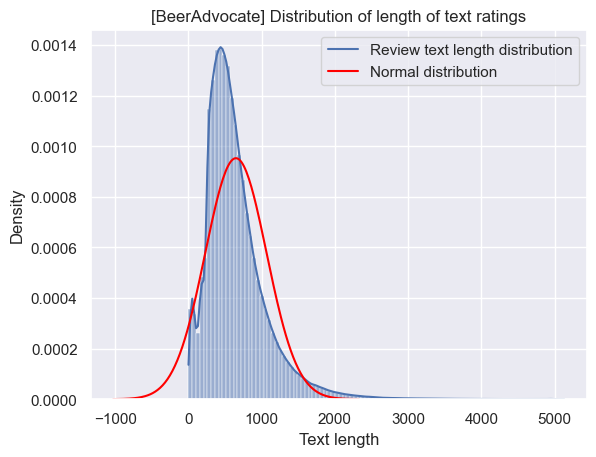

In [33]:
ratings_text_lengths = df_ba_ratings["text"].str.len()

sns.histplot(ratings_text_lengths, bins=100, kde=True, stat="density")


ratings_text_length_mean = ratings_text_lengths.mean()
ratings_text_length_std = ratings_text_lengths.std()

x = np.linspace(
    ratings_text_length_mean - 4 * ratings_text_length_std,
    ratings_text_length_mean + 4 * ratings_text_length_std,
    200,
)
y = stats.norm.pdf(x, ratings_text_length_mean, ratings_text_length_std)

sns.lineplot(x=x, y=y, color="red")

plt.title("[BeerAdvocate] Distribution of length of text ratings")
plt.legend(["Review text length distribution", "Normal distribution"])
plt.xlabel("Text length")

*Interpretation*:

The plot shows the distribution of review text length compared to a normal distribution. We observe a slightly skewed pattern. There is a higher peak of texts with a length of $1000$.

### Ratings (subcategories)

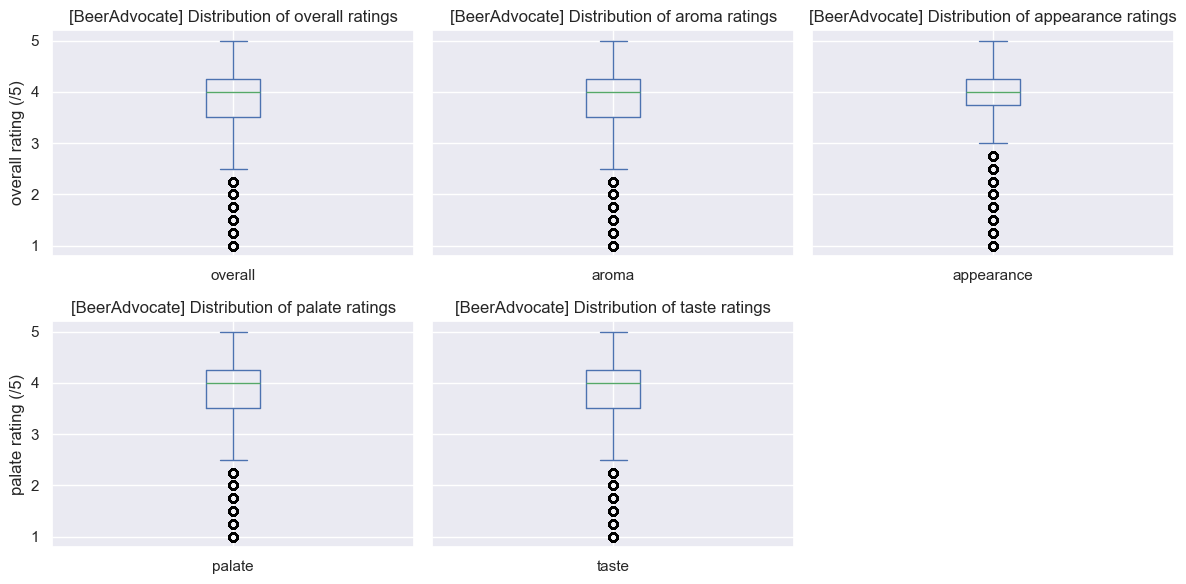

In [34]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 6))
axs = axs.ravel()

for i, c in enumerate(["overall", "aroma", "appearance", "palate", "taste"]):
    df_ba_ratings[c].plot(
        kind="box",
        ax=axs[i],
        title=f"[BeerAdvocate] Distribution of {c} ratings",
        ylabel=f"{c} rating (/5)",
    )

fig.delaxes(axs[-1])
plt.tight_layout()

*Interpretation*:

These boxplots show the distribution of ratings for overall, aroma, appearance, palate, and taste on a scale of 1 to 5. Most ratings for all categories are concentrated between 3.5 and 4.5, showing generally high scores. Taste and overall ratings have slightly higher medians compared to other attributes. The presence of outliers below 2 suggests that while most ratings are positive, a small number of beers received low scores in all categories. This shows the consistency in positive feedback across different attributes, with taste being the most highly rated.

### Correlations

#### Ratings and subcategories

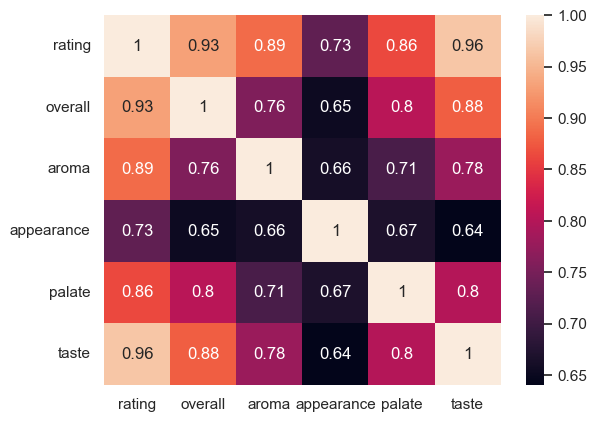

In [35]:
ratings_cross_corr_array = (
    df_ba_ratings[["rating", "overall", "aroma", "appearance", "palate", "taste"]]
    .dropna()
    .to_numpy()
)
corrcoef_ratings = np.corrcoef(ratings_cross_corr_array, rowvar=0)
sns.heatmap(
    corrcoef_ratings,
    annot=True,
    xticklabels=["rating", "overall", "aroma", "appearance", "palate", "taste"],
    yticklabels=["rating", "overall", "aroma", "appearance", "palate", "taste"],
)
plt.show()

*Interpetation*:

We observe the Pearson correlation coefficient between some variables of ratings. Overall, there is a strong positive correlation among most attributes. This matrix shows that subjective qualities like taste and aroma are the most influential in beer evaluations.

In [36]:
del corrcoef_ratings

#### Ratings and past ratings

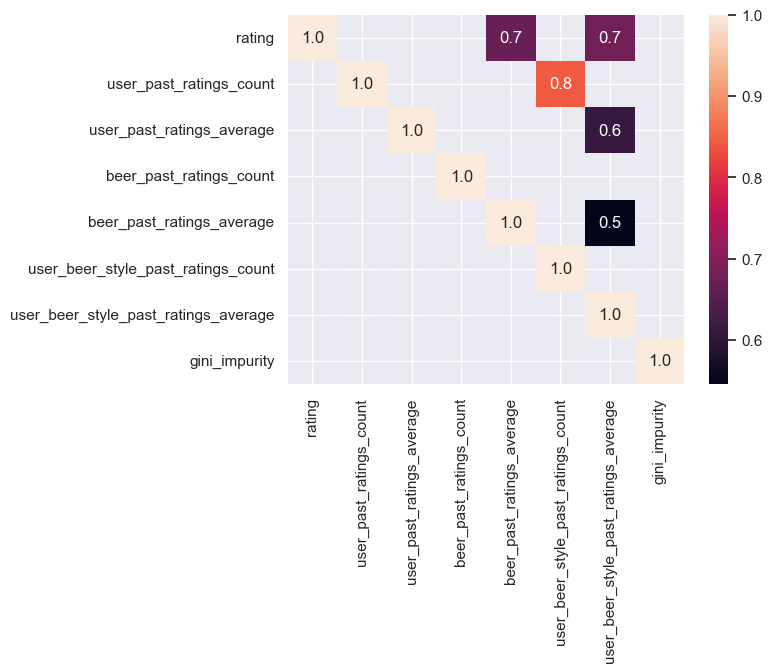

In [37]:
df_ba_ratings_full_corr_coef = df_ba_ratings.drop(
    [
        "user_id",
        "beer_id",
        "brewery_id",
        "date",
        "review",
        "text",
        "overall",
        "aroma",
        "appearance",
        "palate",
        "taste",
        "beer_global_style",
    ],
    axis=1,
)
df_ba_ratings_full_corr_coef.dropna(inplace=True)
corr_columns = df_ba_ratings_full_corr_coef.columns

corrcoef_ratings = np.corrcoef(df_ba_ratings_full_corr_coef.to_numpy(), rowvar=0)

triup_array = np.triu(corrcoef_ratings)

sns.heatmap(
    triup_array,
    annot=True,
    xticklabels=corr_columns,
    yticklabels=corr_columns,
    fmt=".1f",
    mask=np.abs(triup_array) < 0.5,
)
plt.show()

*Interpretation*:

We observe the Pearson correlation matrix of features related to ratings and user or beer characteristics. This heatmap displays the correlations between various features related to ratings and user or beer characteristics.

In [38]:
del df_ba_ratings_full_corr_coef
del corrcoef_ratings
del triup_array

# Data Exploration - Rate Beer

In [39]:
df_rb_beers = pd.read_csv("src/data/rate_beer/beers.csv")
df_rb_breweries = pd.read_csv("src/data/rate_beer/breweries.csv")
df_rb_users = pd.read_csv("src/data/rate_beer/users.csv")
df_rb_ratings = pd.read_csv("src/data/rate_beer/ratings.csv")

## Beer

[RateBeer] Dataframe contains 432818 rows and 14 columns


,beer_id,beer_name,brewery_id,beer_style,ratings_count,ratings_overall_score,style_score,ratings_average,beer_alcohol_by_volume,ratings_average_computed,zscore,matching_ratings_count,matching_ratings_average,beer_global_style
0,410549,33 Export (Gabon),3198,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN,Pale Lager
1,105273,Castel Beer (Gabon),3198,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN,Pale Lager
2,19445,Régab,3198,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN,Pale Lager
3,155699,Ards Bally Black Stout,13538,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667,Stout
4,239097,Ards Belfast 366,13538,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN,Pale Ale


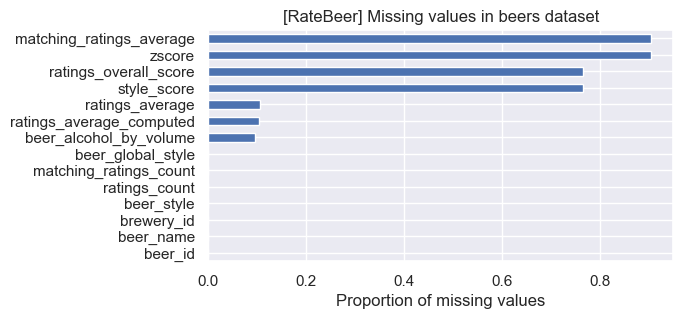

In [40]:
describe_dataframe(df_rb_beers, "RateBeer", "beers")
df_rb_beers.head(5)

*Interpretation*:

This graph gives us the porportion of missing values for different beer's attributes. The z-score and matching ratings for the average are missing for more than 80\% of the data, and will thus not be used in our analysis. Same goes for the ratings overall score and style score with more than 60\% of missing values. 

### Breweries

[RateBeer] Quartiles of the number of beers per brewery : [ 3.  8. 20.]


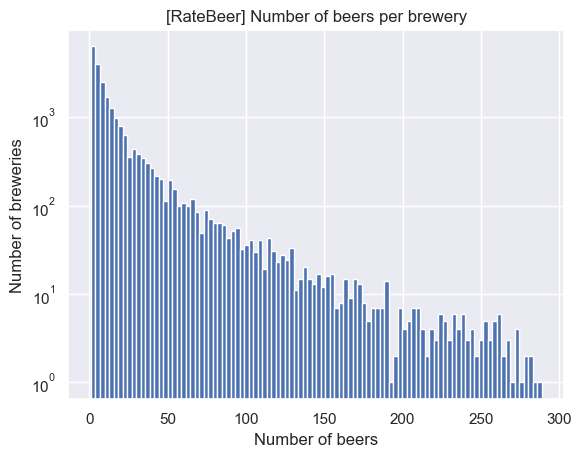

In [41]:
df_beers_by_brewery = df_rb_beers.groupby("brewery_id").size()
df_beers_by_brewery.plot(
    kind="hist",
    log=True,
    bins=100,
    title="[RateBeer] Number of beers per brewery",
    xlabel="Number of beers",
    ylabel="Number of breweries",
)
print(
    f"[RateBeer] Quartiles of the number of beers per brewery : {df_beers_by_brewery.quantile([0.25, 0.5, 0.75]).values}"
)

This graph shows the number of breweries that produce different numbers of beers. We can see that the number of breweries is getting lower as the number of beers produced grows. 

### Beer Style

In [42]:
print(
    f"[RateBeer] Dataset contains data about {df_rb_beers['beer_style'].nunique()} styles of beer"
)

[RateBeer] Dataset contains data about 72 styles of beer


<Axes: title={'center': '[RateBeer] Number of beers per global style'}, xlabel='Beer style', ylabel='Number of beers'>

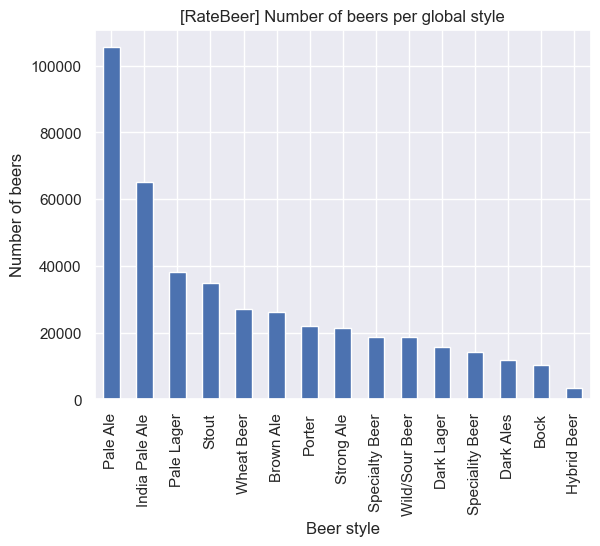

In [43]:
df_rb_beers.groupby("beer_global_style").size().sort_values(ascending=False).plot(
    kind="bar",
    title="[RateBeer] Number of beers per global style",
    xlabel="Beer style",
    ylabel="Number of beers",
)

*Interpretation*:

This graph shows the number of beers for different beer style. We can see that 'Pale Ale' and 'Indian Pale Ale' beer style are totaly dominating the beers present on the 'Rate Beer' website.

### Ratings count

[RateBeer] 10.28% (44474) of beers have no ratings
[RateBeer] Quartiles of the number of ratings per beer : [1. 3. 9.]


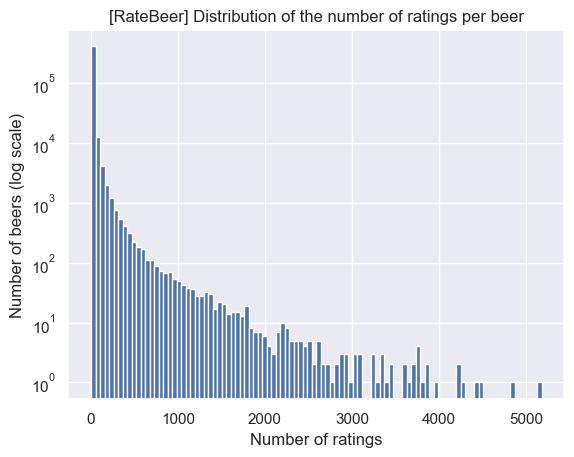

In [44]:
df_rb_beers["ratings_count"].plot(
    kind="hist",
    bins=100,
    log=True,
    title="[RateBeer] Distribution of the number of ratings per beer",
    xlabel="Number of ratings",
    ylabel="Number of beers (log scale)",
)

print(
    f"[RateBeer] {(df_rb_beers['ratings_count'] == 0).mean() * 100:.2f}% ({(df_rb_beers['ratings_count'] == 0).sum()}) of beers have no ratings"
)
print(
    f"[RateBeer] Quartiles of the number of ratings per beer : {df_rb_beers['ratings_count'].quantile([0.25, 0.5, 0.75]).values}"
)

*Interpretation*:

This graph represents the number of beers for different number of ratings. We can notice that the number of beers is decreasing when the number of ratings is increasing, and that a big part of the beers has less than a 1000 ratings. This tells us that we will need to be careful when analysing our data.

### Ratings average

Text(0, 0.5, 'Average rating (/5)')

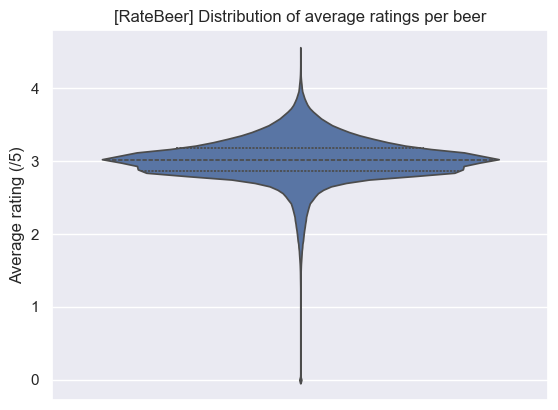

In [45]:
sns.violinplot(df_rb_beers["ratings_average"], inner="quart")
plt.title("[RateBeer] Distribution of average ratings per beer")
plt.ylabel("Average rating (/5)")

*Interpretation*:

We notice that the average is approximately 3/5 for the 'RateBeer' website, and a very large proportion of the ratings lies between 2/5 and 4/5. It is thus not common for user to give a 5 to a beer, neither a 1. 

Text(0.5, 0, 'Average rating (/5)')

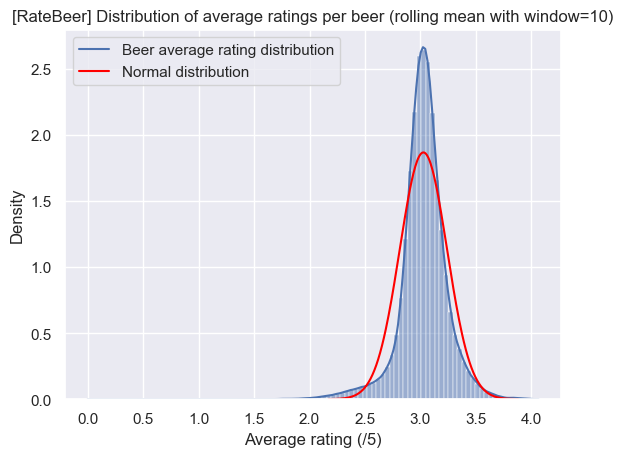

In [46]:
ratings_average_rolling = (
    df_rb_beers[df_rb_beers["ratings_average"].notna()]["ratings_average"]
    .rolling(10)
    .mean()[9:]
)
sns.histplot(ratings_average_rolling, bins=100, kde=True, stat="density")


ratings_average_mean = ratings_average_rolling.mean()
ratings_average_std = ratings_average_rolling.std()

x = np.linspace(
    ratings_average_mean - 4 * ratings_average_std,
    ratings_average_mean + 4 * ratings_average_std,
    200,
)
y = stats.norm.pdf(x, ratings_average_mean, ratings_average_std)

sns.lineplot(x=x, y=y, color="red")

plt.title(
    "[RateBeer] Distribution of average ratings per beer (rolling mean with window=10)"
)
plt.legend(["Beer average rating distribution", "Normal distribution"])
plt.xlabel("Average rating (/5)")

*Interpretation*:

This graph gives the density of the average rating (rolling mean with window = 10), compared to a normal density of same mean and same standard deviation. The density is larger than the normal density at the mean level, which means that the average rating is very likely to be the mean (approximately $3.1$). We can also see that it is more likely for a user to give an average rating lower than the mean that a rating higher than the mean.

In [47]:
ALPHA = 0.01
normality_test_results = stats.normaltest(df_rb_beers["ratings_average"].dropna())
print(f"[RateBeer] {normality_test_results}")
print(
    f"[RateBeer] Normality test for average ratings per beer : reject null hypothesis = {normality_test_results.pvalue < ALPHA}"
)

[RateBeer] NormaltestResult(statistic=np.float64(101308.54918761268), pvalue=np.float64(0.0))
[RateBeer] Normality test for average ratings per beer : reject null hypothesis = True


## Breweries

[RateBeer] Dataframe contains 24189 rows and 6 columns
[RateBeer] Dataset contains data about breweries in 195 countries


,brewery_id,brewery_name,brewery_beers_count,brewery_country,brewery_region,brewery_country_code
0,3198,Sobraga,3,Gabon,NaN,GAB
1,13538,Ards Brewing Co.,13,United Kingdom,Northern Ireland,GBR
2,22304,Barrahooley Craft Brewery,4,United Kingdom,Northern Ireland,GBR
3,22818,Boundary,66,United Kingdom,Northern Ireland,GBR
4,24297,Brewbot Belfast,3,United Kingdom,Northern Ireland,GBR


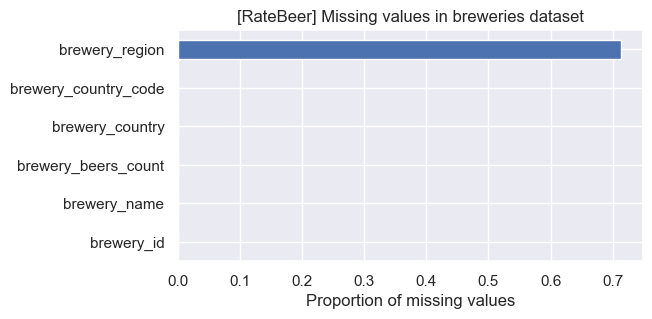

In [48]:
describe_dataframe(df_rb_breweries, "RateBeer", "breweries")
print(
    f'[RateBeer] Dataset contains data about breweries in {df_ba_breweries["brewery_country"].nunique()} countries'
)
df_rb_breweries.head(5)

*Interpretation*:

This graph shows the proportion of missing values for different attributes of the breweries dataset. It seems that only 70\% the Brewery region is missing, which is not a big issue since the brewery country seems not to be missing  

### Country

[RateBeer] Quartiles of the number of breweries per country : [ 2.  5. 28.]


<Axes: title={'center': '[RateBeer] Number of breweries per country (50 largers producers)'}, xlabel='Country', ylabel='Number of breweries (log scale)'>

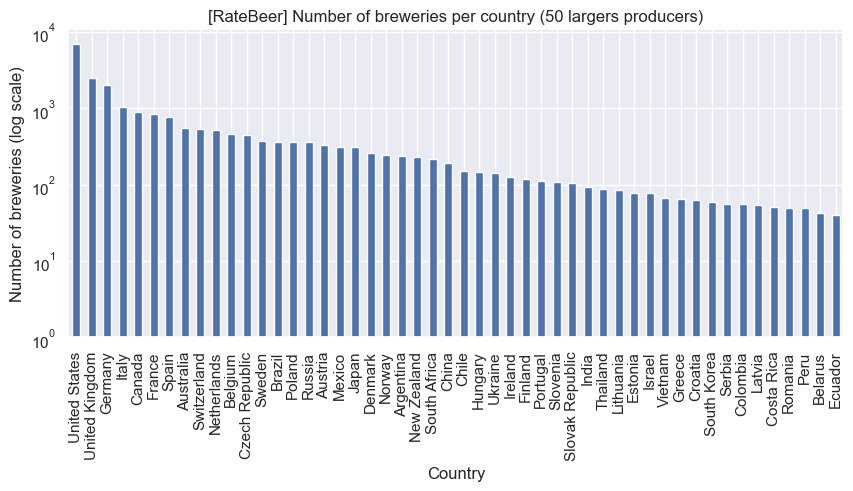

In [49]:
print(
    f'[RateBeer] Quartiles of the number of breweries per country : {df_rb_breweries["brewery_country"].value_counts().quantile([0.25, 0.5, 0.75]).values}'
)

df_rb_breweries["brewery_country"].value_counts().head(50).plot(
    kind="bar",
    log=True,
    figsize=(10, 4),
    title="[RateBeer] Number of breweries per country (50 largers producers)",
    xlabel="Country",
    ylabel="Number of breweries (log scale)",
)

This graph shows the number of breweries for the 50 first countries. We can notice that a large part of the countries have more than a 100 breweries, and that the only three countries with more than 1000 breweries are United Stated, United Kingdom and Germany. Even though United States is leading, United Kingdom and Germany are smallers countries and thus being that high in the ranking shows the importance of beer production in these countries.

## Users

[RateBeer] Dataframe contains 70120 rows and 7 columns


,user_id,user_ratings_count,user_name,user_created_date,user_country,user_region,user_country_code
0,2,52,wade,955533600.0,United States,Georgia,USA
1,3,219,billb,955533600.0,United States,Georgia,USA
2,7,42,young,955533600.0,United States,Georgia,USA
3,10,5,Mark99,955533600.0,United States,Georgia,USA
4,15,1,lazarus99,955533600.0,United States,Georgia,USA


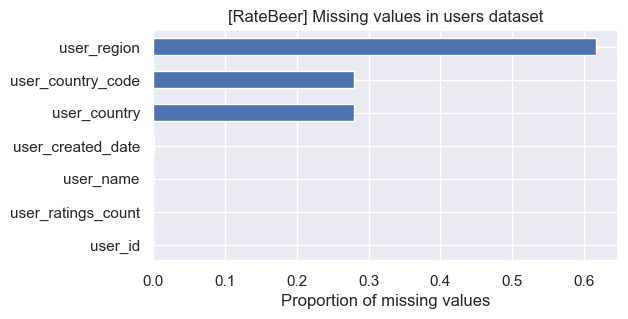

In [50]:
describe_dataframe(df_rb_users, "RateBeer", "users")
df_rb_users.head(5)

*Interpretation*

This graph gives the proportion of missing values for different attributes of the 'users' dataset. Approximately 60\% of the user's region, 27\% of user's country code and user's country.  All of the other attributes are not missing. 

### Ratings

[RateBeer] Quartiles of the number of ratings per user : [ 1.  2. 10.]


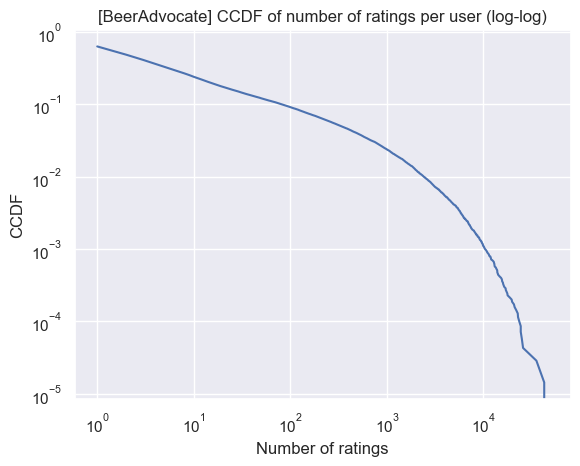

In [51]:
ratings_per_user_CCDF = (
    1
    - df_rb_users["user_ratings_count"].value_counts().sort_index().cumsum()
    / df_rb_users.shape[0]
)

ratings_per_user_CCDF.plot(
    x=df_rb_users["user_ratings_count"].value_counts().sort_index(),
    y=ratings_per_user_CCDF,
    logx=True,
    logy=True,
    title="[BeerAdvocate] CCDF of number of ratings per user (log-log)",
    xlabel="Number of ratings",
    ylabel="CCDF",
)

print(
    f"[RateBeer] Quartiles of the number of ratings per user : {df_rb_users['user_ratings_count'].quantile([0.25, 0.5, 0.75]).values}"
)

*Interpretation*:

This graph shows the complementary cummulative density function of the number of ratings per user. We notice that there is approximately 10\% of users that have more than 100 ratings.

### Country

In [52]:
df_rb_users["user_country"].value_counts().head(10)

user_country
United States     26811
United Kingdom     3302
Canada             3255
Poland             1701
Australia          1476
Netherlands        1095
Denmark            1031
Belgium            1027
Sweden             1004
Italy               924
Name: count, dtype: int64

In [53]:
print(
    f'[RateBeer] Users from United States represent {df_rb_users["user_country"].value_counts(normalize=True).loc['United States'] * 100:.2f}% of accounts'
)

[RateBeer] Users from United States represent 53.05% of accounts


<Axes: title={'center': '[RateBeer] Number of users per country'}, xlabel='Country', ylabel='Number of users (log scale)'>

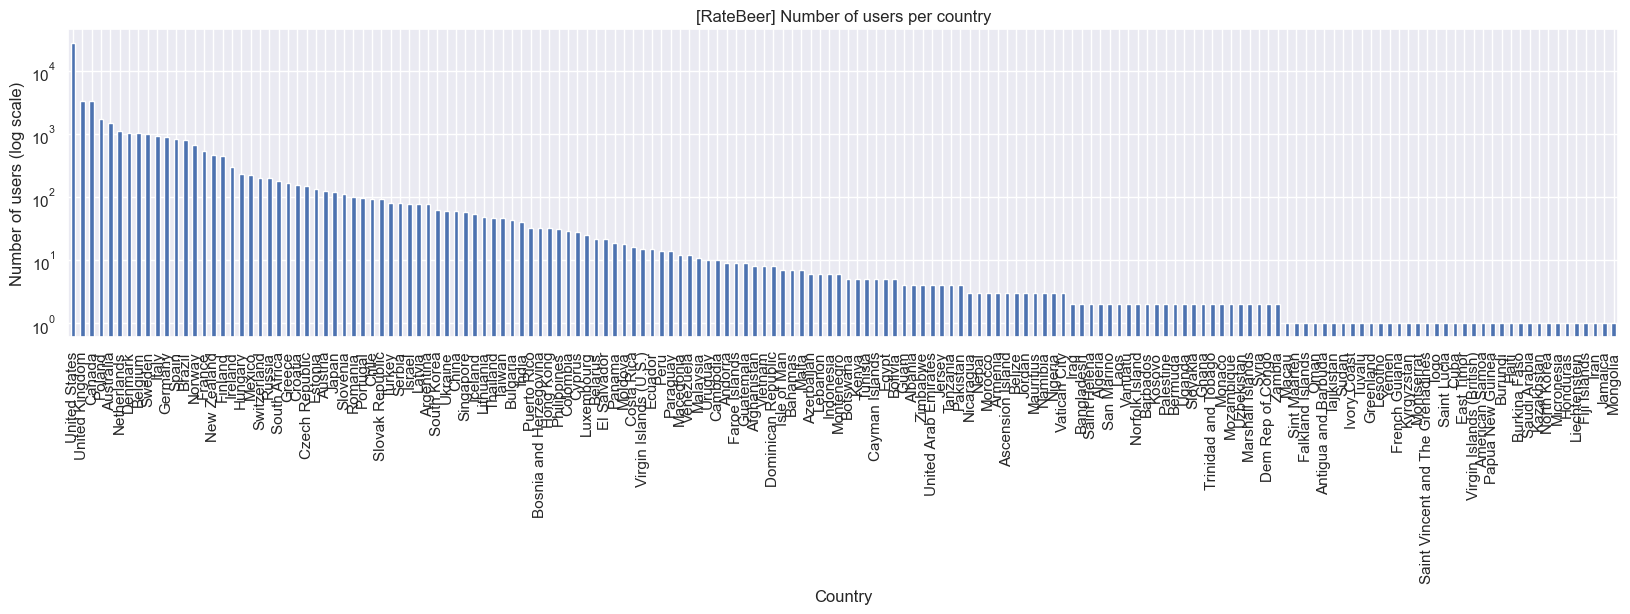

In [54]:
df_rb_users["user_country"].value_counts().plot(
    kind="bar",
    logy=True,
    figsize=(20, 4),
    title="[RateBeer] Number of users per country",
    xlabel="Country",
    ylabel="Number of users (log scale)",
)

*Interpretation*:

The chart shows the number of users per country (on a log scale), with the United States having the overwhelming majority of users. This is expected since the website is based in the U.S., making it more popular among American users. Other countries, the United Kingdom, Canada and Poland, also have significant user representation. However, user numbers sharply decline for other countries, reflecting the localized reach and popularity of the platform.

### Creation date

In [55]:
PRESENT_TIME = df_rb_users["user_created_date"].max()
user_years_since_creation = (
    (PRESENT_TIME - df_rb_users["user_created_date"]) / 3600 / 24 / 365.25
)

In [56]:
print(
    f"[RateBeer] Mean of the number of years since user creation : {user_years_since_creation.mean():.3f}"
)
print(
    f"[RateBeer] Quartiles of the number of years since user creation : {user_years_since_creation.quantile([0.25, 0.5, 0.75]).values}"
)

[RateBeer] Mean of the number of years since user creation : 6.169
[RateBeer] Quartiles of the number of years since user creation : [3.02806297 5.10061602 9.41535478]


<Axes: title={'center': '[RateBeer] Distribution of time elapsed since user account creation (years)'}, xlabel='Years since user creation', ylabel='Number of users'>

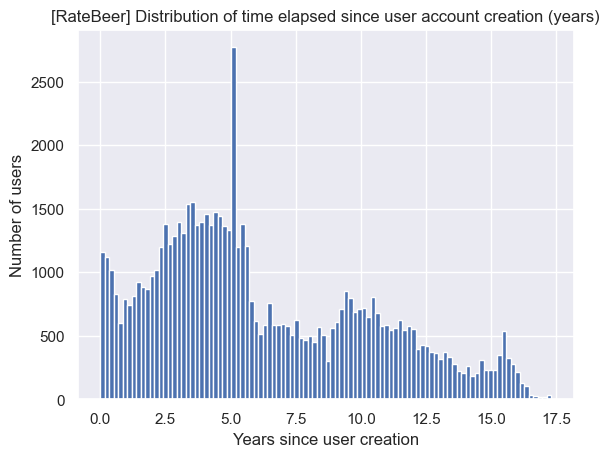

In [57]:
user_years_since_creation.plot(
    kind="hist",
    bins=100,
    title="[RateBeer] Distribution of time elapsed since user account creation (years)",
    xlabel="Years since user creation",
    ylabel="Number of users",
)

*Interpretation*:

The chart shows the distribution of time since user account creation in years. We can notice the creation of the website 17.5 years ago. We can also see that the number of account creations upon time tends to have increasing and decreasing period, even though the increasing periods dominate.

## Ratings

[RateBeer] Dataframe contains 6909161 rows and 19 columns


,user_id,beer_id,brewery_id,date,rating,overall,aroma,appearance,palate,taste,text,user_past_ratings_count,user_past_ratings_average,beer_past_ratings_count,beer_past_ratings_average,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,gini_impurity
0,2,37,9,959076000,1.9,7,2,3,2,5,I hate it when I ask a waiter/waitress if they...,21,3.871429,2,2.25,Pale Lager,1,1.90,0.694849
1,2,47,11,959508000,3.9,15,7,4,4,9,"Not as impressive as Iâd hoped, but very fla...",25,3.768000,2,4.45,Pale Ale,13,3.80,0.757714
2,2,48,11,961927200,4.1,16,8,5,4,8,"Very nice porter, but so far nothing compares ...",31,3.725806,3,4.50,Porter,2,4.50,0.769288
3,2,86,17,957348000,3.5,14,7,4,3,7,"My least favorite Sammy Smith beer, but still ...",7,3.971429,0,NaN,Pale Ale,4,4.15,0.787172
4,2,89,17,957348000,4.5,18,9,5,4,9,Wow - great beer. Old Sammy comes through aga...,8,3.912500,0,NaN,Pale Ale,5,4.22,0.736607


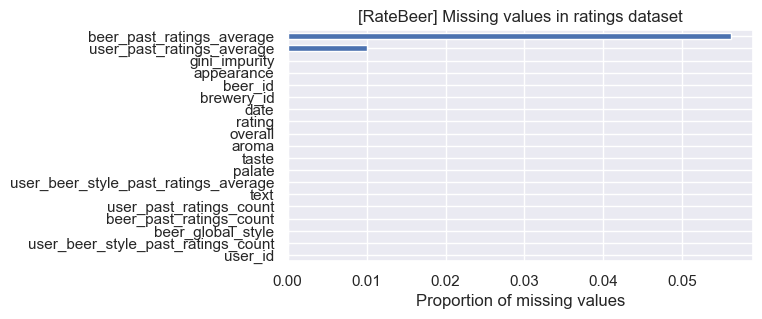

In [58]:
describe_dataframe(df_rb_ratings, "RateBeer", "ratings")
df_rb_ratings.head(5)

*Interpretation*:

This graph shows the proportion of missing values for different attributes of the ratings dataset. We can see that this dataset has only a few missing values. The highest missing porportion is for the attribute 'beer_past_ratings_average' and is lower than 6 $\%$. 

### Date

<Axes: title={'center': '[RateBeer] Number of ratings per quarters'}, xlabel='Quarter', ylabel='Number of ratings'>

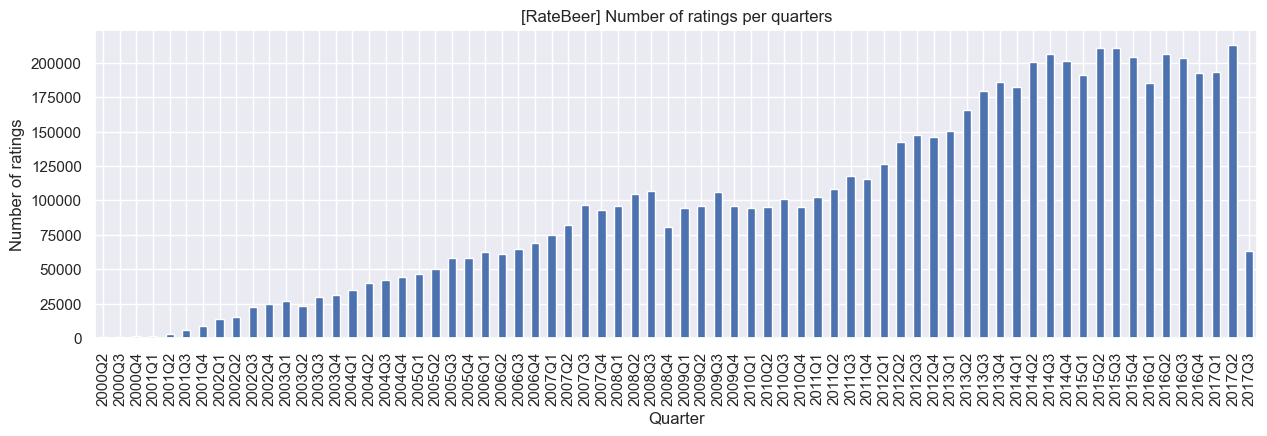

In [59]:
pd.to_datetime(df_rb_ratings["date"], unit="s").dt.to_period(
    "Q"
).value_counts().sort_index().plot(
    kind="bar",
    figsize=(15, 4),
    title="[RateBeer] Number of ratings per quarters",
    xlabel="Quarter",
    ylabel="Number of ratings",
)

*Interpretation*:

This graph shows the number of ratings per quarters per quarter. We can notice that the number of ratings is increasing in time.

### Text

In [60]:
print(
    f"[RateBeer] {(df_ba_ratings['text'].notna()).mean() * 100:.2f}% ({(df_ba_ratings['text'].notna()).sum()}) of the reviews contain a text"
)

print(
    f'[RateBeer] Average length of text in reviews : {df_ba_ratings["text"].str.len().mean():.2f} characters'
)
print(
    f'[RateBeer] Quartiles of the length of text in reviews : {df_ba_ratings["text"].str.len().quantile([0.25, 0.5, 0.75]).values} characters'
)

print(
    f'[RateBeer] Average length of text in reviews : {(df_ba_ratings["text"].str.count(' ') + 1).mean():.2f} words'
)
print(
    f'[RateBeer] Quartiles of the length of text in reviews : {(df_ba_ratings["text"].str.count(' ') + 1).quantile([0.25, 0.5, 0.75]).values} words'
)

[RateBeer] 32.36% (2715709) of the reviews contain a text
[RateBeer] Average length of text in reviews : 648.43 characters
[RateBeer] Quartiles of the length of text in reviews : [377. 561. 816.] characters
[RateBeer] Average length of text in reviews : 113.71 words
[RateBeer] Quartiles of the length of text in reviews : [ 66.  98. 143.] words


Text(0.5, 0, 'Text length')

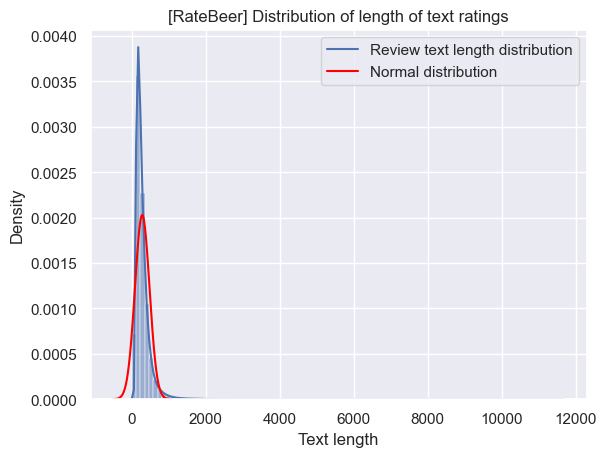

In [ ]:
ratings_text_lengths = df_rb_ratings["text"].str.len()

sns.histplot(ratings_text_lengths, bins=100, kde=True, stat="density")


ratings_text_length_mean = ratings_text_lengths.mean()
ratings_text_length_std = ratings_text_lengths.std()

x = np.linspace(
    ratings_text_length_mean - 4 * ratings_text_length_std,
    ratings_text_length_mean + 4 * ratings_text_length_std,
    200,
)
y = stats.norm.pdf(x, ratings_text_length_mean, ratings_text_length_std)

sns.lineplot(x=x, y=y, color="red")

plt.title("[RateBeer] Distribution of length of text ratings")
plt.legend(["Review text length distribution", "Normal distribution"])
plt.xlabel("Text length")

*Interpretation*:

This graph shows the density of the text ratings' length , compared to a normal distribution with same mean and variance. We can notice that the length of the text rating is on average, and the distribution is left skewed.

### Ratings (subcategories)

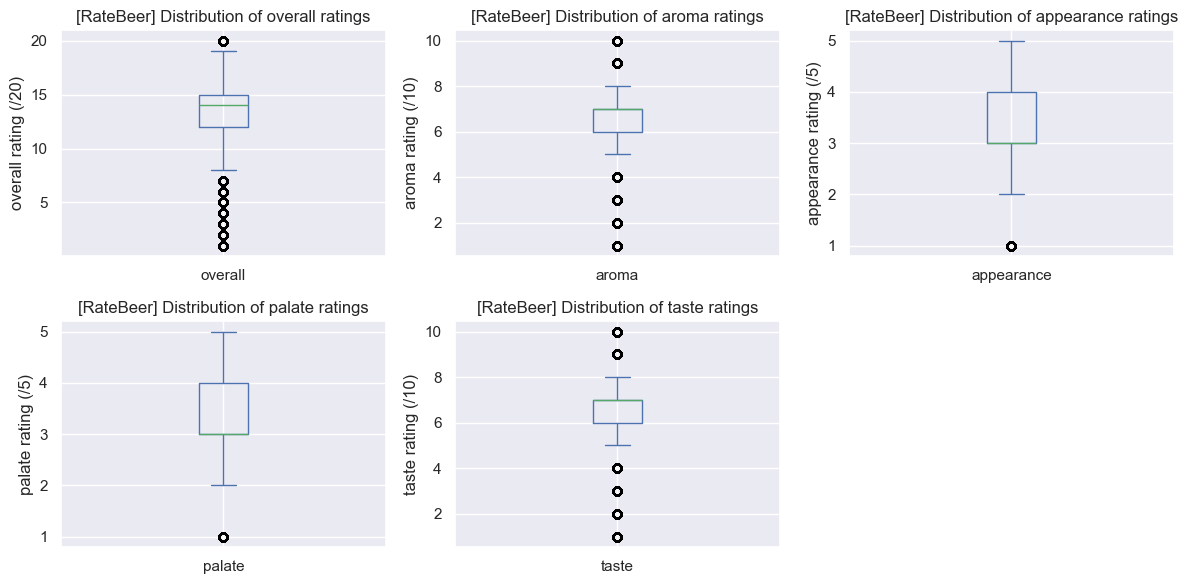

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.ravel()

scales = [20, 10, 5, 5, 10]

for i, c in enumerate(["overall", "aroma", "appearance", "palate", "taste"]):
    df_rb_ratings[c].plot(
        kind="box",
        ax=axs[i],
        title=f"[RateBeer] Distribution of {c} ratings",
        ylabel=f"{c} rating (/{scales[i]})",
    )

fig.delaxes(axs[-1])
plt.tight_layout()

*Interpretation*:

These boxplots show the distribution of ratings for overall on a scale of 1 to 20, aroma on a scale on 1 to 10, appearance on a scale on 1 to 5, palate on a scale of 1 to 5, and taste on a scale of 1 to 10. Most ratings are between 3 and 4 for rating on 5, between 6 and 7 for rating on 10 and between 12 and 15 for ratings on 20, showing generally high scores. 

### Correlations

#### Ratings and subcategories

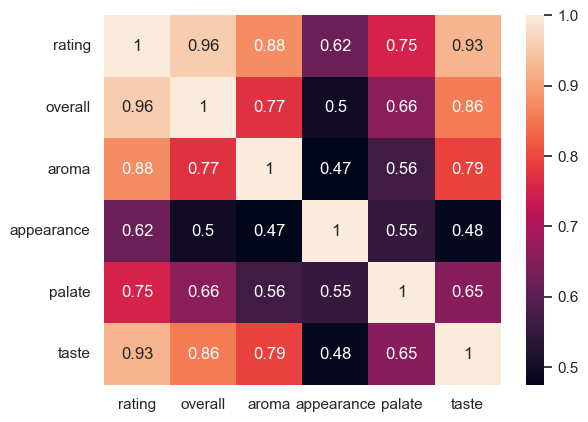

In [ ]:
ratings_cross_corr_array = (
    df_rb_ratings[["rating", "overall", "aroma", "appearance", "palate", "taste"]]
    .dropna()
    .to_numpy()
)
corrcoef_ratings = np.corrcoef(ratings_cross_corr_array, rowvar=0)
sns.heatmap(
    corrcoef_ratings,
    annot=True,
    xticklabels=["rating", "overall", "aroma", "appearance", "palate", "taste"],
    yticklabels=["rating", "overall", "aroma", "appearance", "palate", "taste"],
)
plt.show()

*Interpetation*:

We observe the Pearson correlation coefficient between some attributes of ratings. Overall, there is a strong positive correlation among most attributes. Appearance is the variable with le smalest correlation with other attributes. This matrix shows that subjective qualities like taste and aroma are the most influential in beer evaluations.

In [ ]:
del corrcoef_ratings

#### Ratings and past ratings

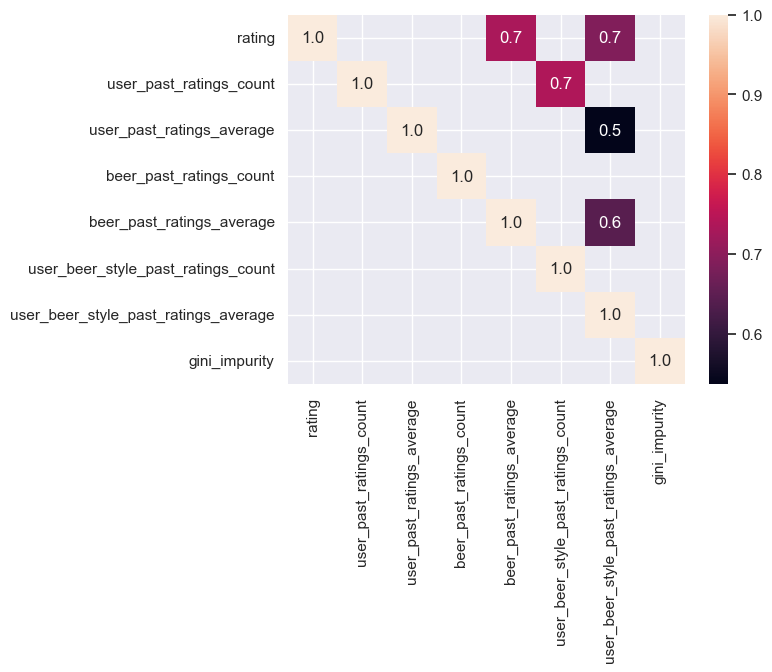

In [ ]:
df_rb_ratings_full_corr_coef = df_rb_ratings.drop(
    [
        "user_id",
        "beer_id",
        "brewery_id",
        "date",
        "text",
        "overall",
        "aroma",
        "appearance",
        "palate",
        "taste",
        "beer_global_style",
    ],
    axis=1,
)
df_rb_ratings_full_corr_coef.dropna(inplace=True)
corr_columns = df_rb_ratings_full_corr_coef.columns

corrcoef_ratings = np.corrcoef(df_rb_ratings_full_corr_coef.to_numpy(), rowvar=0)

triup_array = np.triu(corrcoef_ratings)

sns.heatmap(
    triup_array,
    annot=True,
    xticklabels=corr_columns,
    yticklabels=corr_columns,
    fmt=".1f",
    mask=np.abs(triup_array) < 0.5,
)
plt.show()

*Interpretation*:

We observe the Pearson correlation matrix of features related to ratings and user or beer characteristics. This heatmap displays the correlations between various features related to ratings and user or beer characteristics.

In [ ]:
del df_rb_ratings_full_corr_coef
del corrcoef_ratings
del triup_array